In [74]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

from collections import Counter

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns
from netgraph import Graph

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

from sklearn.decomposition import PCA

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe

import sqlite3

In [2]:
import split_images
reload(split_images)
from split_images import split_geometry, haversine, calc_segment_count

In [3]:
from analysis_image import AnalysisImage
from keras.preprocessing import image

In [4]:
ee.Authenticate()
ee.Initialize()

In [5]:
SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
years = [2018, 2019, 2020, 2021, 2022, 2023]

In [6]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [109]:
tegu_200_eloisa = ''

In [7]:
# Load eloisa_databases/tegu_200x200_flatten.pkl
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'rb') as f:
    tegu_200_eloisa = pickle.load(f)

tegu_200_eloisa._database = sqlite3.connect(tegu_200_eloisa.db_path)

In [8]:
from tensorflow.keras.applications import ResNet152V2 as resnet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_p

In [9]:
cluster_sequence = tegu_200_eloisa.get_cluster_sequences(years=years, model=resnet)

In [10]:
# Get counts of all clusters
cluster_counts = Counter([cluster for sequence in cluster_sequence for cluster in sequence])

In [86]:
# What percent of sequences had the same cluster every year?

for i in range(1, 7):
    same_cluster = [sequence for sequence in cluster_sequence if len(set(sequence)) == i]
    print(f'Sequences with {i} clusters: {len(same_cluster)} ({len(same_cluster) / len(cluster_sequence) * 100:.2f}%)')

Sequences with 1 clusters: 783 (22.64%)
Sequences with 2 clusters: 1317 (38.09%)
Sequences with 3 clusters: 942 (27.24%)
Sequences with 4 clusters: 353 (10.21%)
Sequences with 5 clusters: 60 (1.74%)
Sequences with 6 clusters: 3 (0.09%)


## PYSAN

In [11]:
import pysan.multi
reload(pysan.multi)
from pysan.multi import plot_sequences

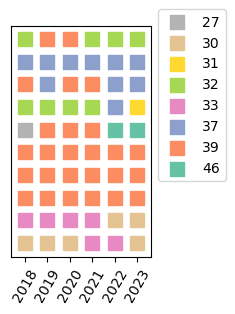

In [12]:
plt = plot_sequences(cluster_sequence[20:30], colors='Set2_r', x_labels=years)
plt.show()

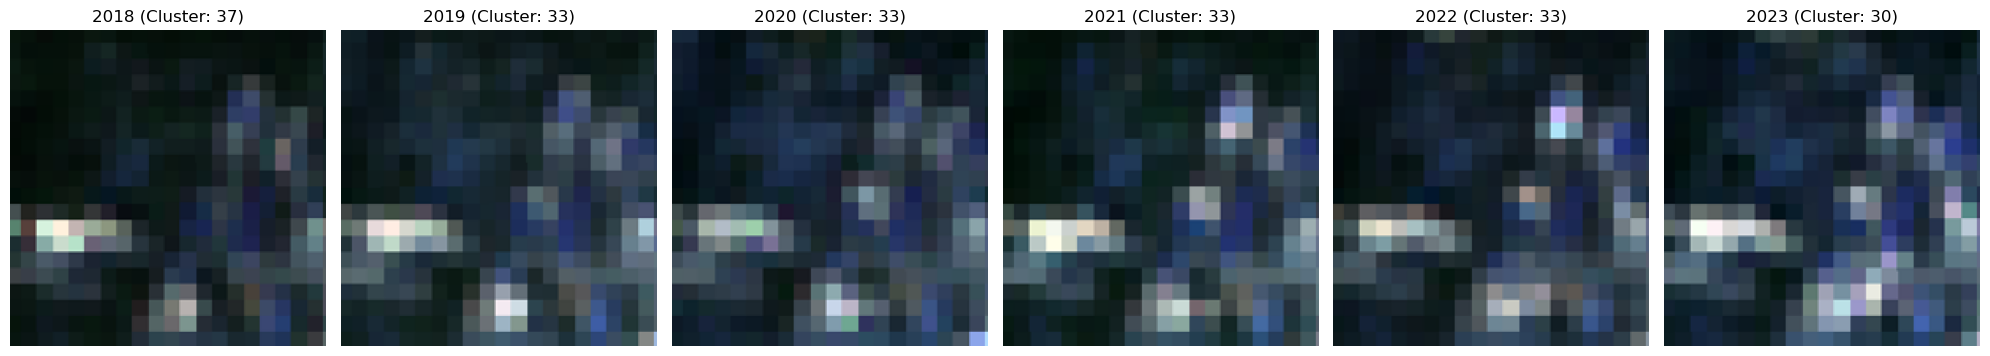

In [13]:
tegu_200_eloisa.show_clip_by_year(years=years, index=97, model=resnet)

## MARKOV CHAINS

In [14]:
import networkx as nx
from collections import defaultdict

In [15]:
class SelfLoop():
    def __init__(self, v_scale=0.25, h_scale=0.25, nodesize=100):
        self.v_scale = v_scale
        self.h_scale = h_scale
        self.nodesize = nodesize

    def selfloopstyle(self, posA, posB, *args, **kwargs):
        from matplotlib.path import Path

        selfloop_ht = 0.005 * self.nodesize

        data_loc = ax.transData.inverted().transform(posA)
        v_shift = self.v_scale * selfloop_ht
        h_shift = v_shift * self.h_scale

        path = [
            data_loc + np.asarray([0, v_shift]),
            data_loc + np.asarray([h_shift, v_shift]),
            data_loc + np.asarray([h_shift, 0]),
            data_loc,
            data_loc + np.asarray([-h_shift, 0]),
            data_loc + np.asarray([-h_shift, v_shift]),
            data_loc + np.asarray([0, v_shift]),
        ]

        ret = Path(ax.transData.transform(path), [1, 4, 4, 4, 4, 4, 4])

        return ret
    
    def style(self):
        return self.selfloopstyle


In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# sequences
sequences = cluster_sequence

# Count transitions
transition_counts = defaultdict(lambda: defaultdict(int))
state_counts = defaultdict(int)
for sequence in sequences:
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        transition_counts[current_state][next_state] += 1
        state_counts[current_state] += 1
    # Count the last state in the sequence
    state_counts[sequence[-1]] += 1

# Normalize counts to obtain transition probabilities
transition_matrix = defaultdict(lambda: defaultdict(float))
for state, next_states in transition_counts.items():
    total_transitions = sum(next_states.values())
    for next_state, count in next_states.items():
        transition_matrix[state][next_state] = count / total_transitions

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for state, next_states in transition_matrix.items():
    for next_state, probability in next_states.items():
        G.add_edge(state, next_state, weight=probability, label=f"{probability:.2f}")

node_sizes = {state: state_counts[state] * 0.001 if state_counts[state] * 0.001 > 1 else 1 for state in G.nodes()}
# node_sizes = {state: state_counts[state] * 0.001 for state in G.nodes()}

In [17]:
# Compute communities
communities = nx.community.greedy_modularity_communities(G, weight='weight')

# Convert to list of lists for plotting
communities = [list(community) for community in communities]

In [18]:
communities

[[4, 39, 44, 12, 46, 15, 48, 49, 23],
 [32, 9, 41, 43, 14, 18, 26, 29],
 [1, 2, 3, 5, 6, 37, 7, 47],
 [20, 42, 8, 25, 40, 30],
 [24, 0, 19, 31],
 [33, 10, 35, 28],
 [27, 21, 38],
 [34],
 [16],
 [45],
 [36],
 [11],
 [22],
 [17],
 [13]]

In [19]:
community_to_color = {
    0 : 'tab:green',
    1 : 'tab:brown',
    2 : 'tab:blue',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:orange',
    6 : 'tab:pink',
    7 : 'tab:gray',
    8 : 'tab:gray',
    9 : 'tab:gray',
    10 : 'tab:gray',
    11 : 'tab:gray',
    12 : 'tab:gray',
    13 : 'tab:gray',
    14 : 'tab:gray',
}

tableau_palette = {
    'tab:blue': '#1f77b4',
    'tab:orange': '#ff7f0e',
    'tab:green': '#2ca02c',
    'tab:red': '#d62728',
    'tab:purple': '#9467bd',
    'tab:brown': '#8c564b',
    'tab:pink': '#e377c2',
    'tab:gray': '#7f7f7f',
    'tab:olive': '#bcbd22',
    'tab:cyan': '#17becf'
}

# Create a colormap dictionary for communities based on the community_to_color dictionary.
# It should map the cluster number to the color of the community it belongs to.
community_cluster_cmap = {}
for i, community in enumerate(communities):
    for cluster in community:
        community_cluster_cmap[cluster] = community_to_color[i]

# Convert the values in community_cluster_cmap to the hex values using the tableau_palette dictionary
community_cluster_cmap = {cluster: tableau_palette[color] for cluster, color in community_cluster_cmap.items()}

C:\Users\Juanes\AppData\Local\Temp\ipykernel_7536\1482925639.py:102: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], arrowsize=w, node_size=node_sizes)


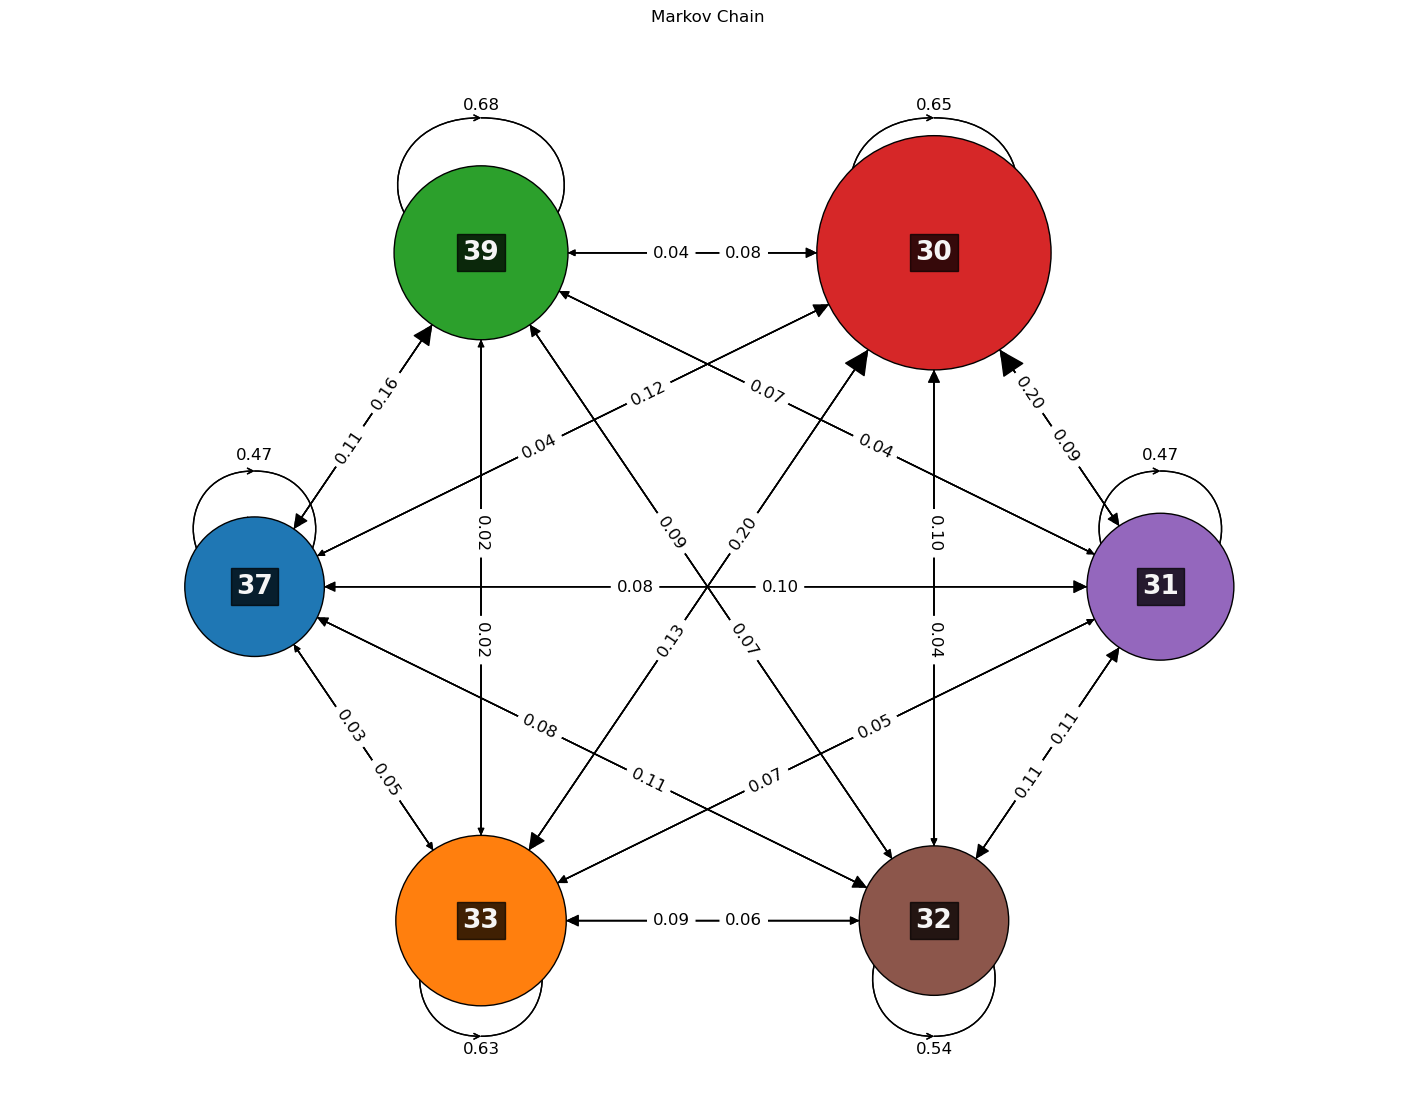

In [20]:
# sequences
sequences = cluster_sequence

# Count transitions
transition_counts = defaultdict(lambda: defaultdict(int))
state_counts = defaultdict(int)
for sequence in sequences:
    for i in range(len(sequence) - 1):
        current_state = sequence[i]
        next_state = sequence[i + 1]
        transition_counts[current_state][next_state] += 1
        state_counts[current_state] += 1
    # Count the last state in the sequence
    state_counts[sequence[-1]] += 1

# Filter out states with fewer than 10 appearances
filtered_states = {state for state, count in state_counts.items() if count >= 500}

# Normalize counts to obtain transition probabilities
transition_matrix = defaultdict(lambda: defaultdict(float))
for state, next_states in transition_counts.items():
    if state in filtered_states:
        total_transitions = sum(next_states[next_state] for next_state in next_states if next_state in filtered_states)
        for next_state, count in next_states.items():
            if next_state in filtered_states:
                transition_matrix[state][next_state] = count / total_transitions

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph, filtering out low probability transitions
for state, next_states in transition_matrix.items():
    for next_state, probability in next_states.items():
        if probability >= 0.01:
            G.add_edge(state, next_state, weight=probability, label=f"{probability:.2f}")

# Combine back-and-forth edge labels
combined_edge_labels = {}
for u, v, data in G.edges(data=True):
    if (v, u) in G.edges:
        combined_label = f"{data['label']} | {G[v][u]['label']}"
        combined_edge_labels[(u, v)] = combined_label
        combined_edge_labels[(v, u)] = combined_label
    else:
        combined_edge_labels[(u, v)] = data['label']

# Get the edge labels
edge_labels = nx.get_edge_attributes(G, 'label')

# Calculate node sizes based on state counts
node_sizes = [state_counts[state] * 4.6 for state in G.nodes()]


fig, ax = plt.subplots(figsize=(18,14))

# Add more white space around the graph
plt.margins(0.2)


pos = nx.shell_layout(G)  # positions for all nodes, k controls the distance between nodes

# Change positions of nodes 33 and 37 in pos
pos[33], pos[37] = pos[37], pos[33]
pos[37], pos[39] = pos[39], pos[37]

# Colormap for nodes
colours_mapped = {30: '#0d0887',
        31: '#44039e',
        32: '#910ea3',
        33: '#a72197',
        37: '#f1834c',
        39: '#f0f921'}

# Make the colors more muted
for key in colours_mapped:
    colours_mapped[key] = sns.desaturate(colours_mapped[key], 0.75)

node_colors = [community_cluster_cmap.get(node, '#000000') for node in G.nodes()]


nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_colors, font_size=22, 
        edgecolors='black', alpha=1)


# Modify the node labels so that they are more readable
node_labels = {node: node for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=19, font_color='whitesmoke', font_weight='bold', bbox=dict(facecolor='black', alpha=0.75))



# Draw self-loop edges separately with a different connection style
loop_edges = [(u, v) for u, v in G.edges() if u == v]


# Remove self-loop edges from the graph
G.remove_edges_from(loop_edges)

# Loop through each edge and change the size of the arrow head
arrowhead_scaler = 200
for edge in G.edges(data=True):
    w = edge[2]['weight'] * arrowhead_scaler
    nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], arrowsize=w, node_size=node_sizes)


e = nx.draw_networkx_edges(G, pos, edgelist=loop_edges, connectionstyle='arc3,rad=0.5')


label_font_size = 12

# Draw combined edge labels with a slight offset
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.42, font_size=label_font_size)

# Add in the self-loop style

e[1]._connector = SelfLoop(0.6, 0.6).style()
# e[1].set_mutation_scale(0.47 * arrowhead_scaler)
ax.add_patch(e[1])
ax.text(-1, 0.34, "0.47", fontsize=label_font_size, ha='center', va='center')

e[0]._connector = SelfLoop(0.7, 0.7).style()
# e[0].set_mutation_scale(0.68 * arrowhead_scaler)  # Set the arrowhead size
ax.add_patch(e[0])
ax.text(-0.5, 1.25, "0.68", fontsize=label_font_size, ha='center', va='center')

e[2]._connector = SelfLoop(-0.6, -0.6).style()
# e[2].set_mutation_scale(0.54 * arrowhead_scaler)
ax.add_patch(e[2])
ax.text(0.5, -1.2, "0.54", fontsize=label_font_size, ha='center', va='center')

e[3]._connector = SelfLoop(0.6, 0.6).style()
# e[3].set_mutation_scale(0.47 * arrowhead_scaler)
ax.add_patch(e[3])
ax.text(1, 0.34, "0.47", fontsize=label_font_size, ha='center', va='center')

e[4]._connector = SelfLoop(0.7, 0.7).style()
# e[4].set_mutation_scale(0.65 * arrowhead_scaler)
ax.add_patch(e[4])
ax.text(0.5, 1.25, "0.65", fontsize=label_font_size, ha='center', va='center')

e[5]._connector = SelfLoop(-0.6, -0.6).style()
# e[5].set_mutation_scale(0.63 * arrowhead_scaler)
ax.add_patch(e[5])
ax.text(-0.5, -1.2, "0.63", fontsize=label_font_size, ha='center', va='center')

for i in range(0, 6):
    e[i].set_arrowstyle('->')


plt.title("Markov Chain")
plt.show()

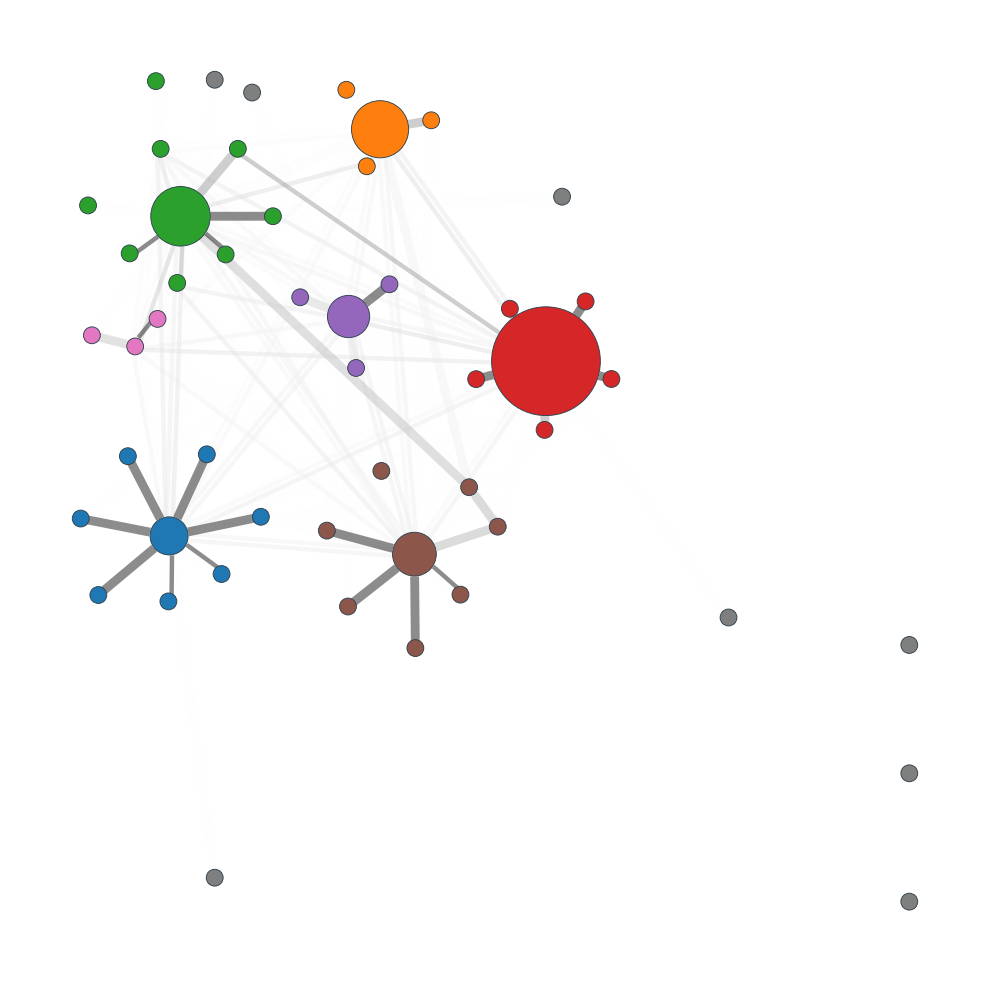

In [341]:
# Create a dictionary to map each node to its community
node_to_community = {}
for community_id, community in enumerate(communities):
    for node in community:
        node_to_community[node] = community_id

community_to_color = {
    0 : 'tab:green',
    1 : 'tab:brown',
    2 : 'tab:blue',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:orange',
    6 : 'tab:pink',
    7 : 'tab:gray',
    8 : 'tab:gray',
    9 : 'tab:gray',
    10 : 'tab:gray',
    11 : 'tab:gray',
    12 : 'tab:gray',
    13 : 'tab:gray',
    14 : 'tab:gray',
}

node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}


plt.figure(figsize=(4, 8), dpi=300)

# Remove self-loop edges
G.remove_edges_from(nx.selfloop_edges(G))

# Plot the graph using NetGraph
Graph(G,
      node_color=node_color, 
      node_edge_width=0.1, 
      edge_alpha=0.5,
      node_layout='community', 
      node_layout_kwargs=dict(node_to_community=node_to_community),
    #   edge_layout='bundled',
      edge_layout_kwargs=dict(k=500),
      node_size=node_sizes,
      seed=2
)

plt.show()

In [24]:
# Create table of transition probabilities
transition_table = pd.DataFrame(transition_matrix).T.fillna(0)

# Order the rows and columns
transition_table = transition_table.sort_index(axis=0).sort_index(axis=1)

# Display the table
transition_table

,1,6,7,8,10,11,12,13,14,15,...,39,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000


In [25]:
# for all n-grams in the sequences, count the number of times each n-gram appears
n_gram_counts = {}
for sequence in sequences:
    for i in range(5):
        n_gram_length = i + 1

        for j in range(len(sequence) - n_gram_length + 1):
            n_gram = tuple(sequence[j:j + n_gram_length])

            if n_gram not in n_gram_counts:
                n_gram_counts[n_gram] = 0

            n_gram_counts[n_gram] += 1

In [26]:
# Order n_gram_counts by frequency
n_gram_counts = dict(sorted(n_gram_counts.items(), key=lambda x: x[1], reverse=True))

In [27]:
# What were the most common n-grams that end with lookup_item?
lookup_item = 37
key_clusters = [30, 31, 32, 33, 37, 39]

for lookup_item in key_clusters:
    n_grams_ending_with_30 = {n_gram: count for n_gram, count in n_gram_counts.items() if n_gram[-1] == lookup_item}


    # Remove n-grams with the final element repeated
    for n_gram in list(n_grams_ending_with_30.keys()):
        if len(n_gram) == 1:
            continue

        if n_gram[-1] == n_gram[-2] or n_gram[0] == n_gram[1] or n_gram[0] == n_gram[-1]:
            del n_grams_ending_with_30[n_gram]



    for key_cluster in key_clusters:
        for n_gram in list(n_grams_ending_with_30.keys()):
        
            
            if key_cluster == lookup_item or n_gram == (key_cluster, lookup_item) or len(n_gram) == 1 or n_gram[0] != key_cluster:
                continue

            to_beat = n_grams_ending_with_30[(key_cluster, lookup_item)]

            

            if (to_beat * 0.20) < n_grams_ending_with_30[n_gram]:
                print((key_cluster, lookup_item))
                print(to_beat)
                print("-----------------------------")
                print(n_gram)
                print(n_grams_ending_with_30[n_gram])
                print("")



# n_grams_ending_with_30


(39, 31)
112
-----------------------------
(39, 30, 31)
27

(31, 33)
133
-----------------------------
(31, 30, 33)
38

(39, 33)
63
-----------------------------
(39, 30, 33)
22



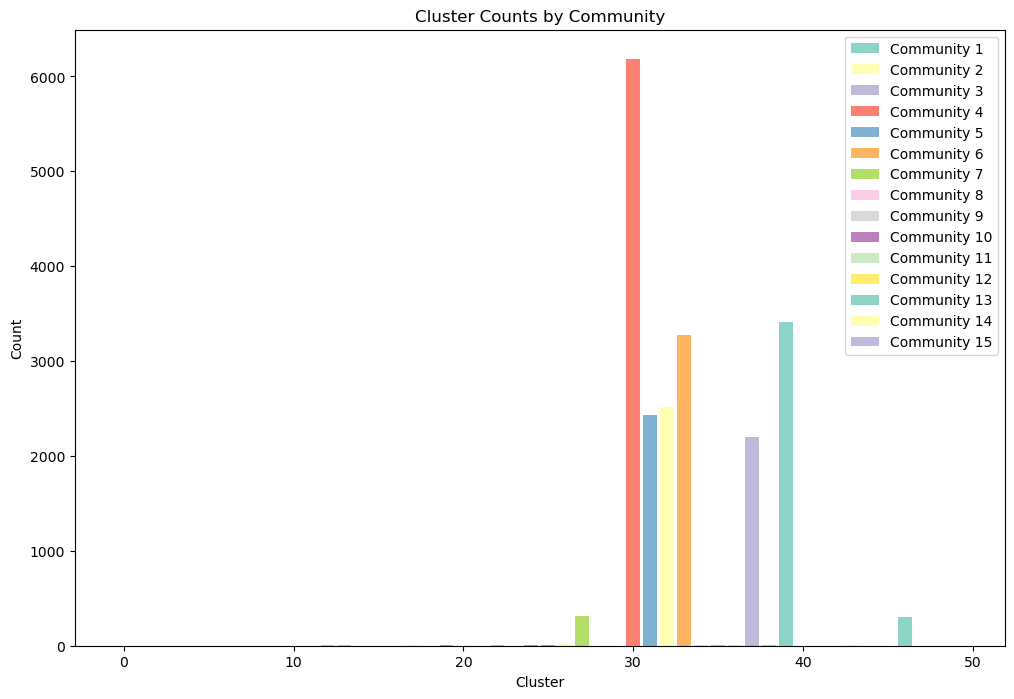

In [28]:
# Plot the cluster counts in a bar chart but color the bars based on the community
plt.figure(figsize=(12, 8))
colors = sns.color_palette('Set3', len(communities))
for i, community in enumerate(communities):
    community_counts = {state: count for state, count in state_counts.items() if state in community}
    plt.bar(community_counts.keys(), community_counts.values(), color=colors[i], label=f"Community {i + 1}")

plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cluster Counts by Community")
plt.legend()
plt.show()

In [29]:
# Since closeness centrality assumes the edge weights are distances, but we have probabilities, we need to convert them
# to distances. We can do this by taking the negative logarithm of the probabilities.
for u, v, data in G.edges(data=True):
    data['distance'] = -np.log(data['weight'])

In [30]:
# Whats the least cost path from 30 to 39?
nx.all_shortest_paths(G, 30, 39, weight='weight')

<generator object _build_paths_from_predecessors at 0x00000233BB087BA0>

In [31]:
key_clusters = [30, 31, 32, 33, 37, 39]
# Loop through all pairs of key clusters and calculate the shortest path
for i, start in enumerate(key_clusters):
    for j, end in enumerate(key_clusters):
        if i == j:
            continue

        shortest_path = nx.shortest_path(G, start, end, weight='weight')
        shortest_path_length = nx.shortest_path_length(G, start, end, weight='weight')
        print(f"Shortest path from {start} to {end}: {shortest_path} with length {shortest_path_length:.2f}")

Shortest path from 30 to 31: [30, 46, 31] with length 0.07
Shortest path from 30 to 32: [30, 32] with length 0.04
Shortest path from 30 to 33: [30, 46, 33] with length 0.04
Shortest path from 30 to 37: [30, 37] with length 0.04
Shortest path from 30 to 39: [30, 39] with length 0.04
Shortest path from 31 to 30: [31, 27, 33, 39, 30] with length 0.14
Shortest path from 31 to 32: [31, 27, 32] with length 0.07
Shortest path from 31 to 33: [31, 27, 33] with length 0.04
Shortest path from 31 to 37: [31, 27, 37] with length 0.07
Shortest path from 31 to 39: [31, 27, 33, 39] with length 0.06
Shortest path from 32 to 30: [32, 30] with length 0.10
Shortest path from 32 to 31: [32, 46, 31] with length 0.07
Shortest path from 32 to 33: [32, 46, 33] with length 0.04
Shortest path from 32 to 37: [32, 46, 33, 37] with length 0.07
Shortest path from 32 to 39: [32, 46, 33, 39] with length 0.07
Shortest path from 33 to 30: [33, 39, 30] with length 0.10
Shortest path from 33 to 31: [33, 31] with length 0.

In [32]:
# Compute closeness centrality
closeness = nx.closeness_centrality(G, distance='distance')

# Sort the closeness values
closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

closeness

[(30, 0.36149491753217877),
 (39, 0.3381261918515652),
 (37, 0.30793807856090893),
 (32, 0.295345309084976),
 (31, 0.2870200542796125),
 (33, 0.25698465001140164),
 (27, 0.1567262664440016),
 (46, 0.15479024337206307),
 (26, 0.09474448273560826),
 (12, 0.08772667554680637),
 (43, 0.08257974156919692),
 (7, 0.08139948396302157),
 (8, 0.08022908883804446),
 (20, 0.08022908883804446),
 (38, 0.07991535444607176),
 (25, 0.07926448762435638),
 (16, 0.07829391784806439),
 (45, 0.07829391784806439),
 (35, 0.0776328538160684),
 (14, 0.07658492886298345),
 (34, 0.07643613344347301),
 (23, 0.07643613344347301),
 (36, 0.07628845235949346),
 (1, 0.07574012203087448),
 (49, 0.07550253009190508),
 (28, 0.07475887823506087),
 (47, 0.07452495102585824),
 (42, 0.07438640954812642),
 (6, 0.07422867451849327),
 (29, 0.07421981912814496),
 (18, 0.07421981912814496),
 (41, 0.07407734555318558),
 (44, 0.07399604561646018),
 (15, 0.07399604561646018),
 (11, 0.07323916216648456),
 (21, 0.0725435057133822),
 (1

## HIDDEN MARKOV MODEL

In [129]:
from SimpleHOHMM import HiddenMarkovModelBuilder as Builder

In [130]:
possible_observations = [str(i) for i in range(0, 50)]
sequences = [[str(i) for i in seq] for seq in cluster_sequence]
possible_states = ['0', '1', '2']

In [131]:
builder = Builder()

In [132]:
builder = Builder()
hmm = builder.build_unsupervised(
    single_states=possible_states,
    all_obs=possible_observations,
    distribution='uniform',
    highest_order=3
)

In [ ]:
hmm.learn(sequences, k_smoothing=0.001)

In [ ]:
hmm.display_parameters()

Starting probabilities (pi):
{'1': 0.3333333333333333, '0': 0.3333333333333333, '2': 0.3333333333333333}
{'1-1': 0.1111111111111111, '1-0': 0.1111111111111111, '1-2': 0.1111111111111111, '0-1': 0.1111111111111111, '0-0': 0.1111111111111111, '0-2': 0.1111111111111111, '2-1': 0.1111111111111111, '2-0': 0.1111111111111111, '2-2': 0.1111111111111111}
{'1-1-1': 0.32554365465757873, '1-1-0': 0.32554365465757873, '1-1-2': 0.32554365465757873, '1-0-1': 0.0009737098344693283, '1-0-0': 0.0009737098344693283, '1-0-2': 0.0009737098344693283, '1-2-1': 0.0009737098344693283, '1-2-0': 0.0009737098344693283, '1-2-2': 0.0009737098344693283, '0-1-1': 0.0009737098344693283, '0-1-0': 0.0009737098344693283, '0-1-2': 0.0009737098344693283, '0-0-1': 0.0009737098344693283, '0-0-0': 0.0009737098344693283, '0-0-2': 0.0009737098344693283, '0-2-1': 0.0009737098344693283, '0-2-0': 0.0009737098344693283, '0-2-2': 0.0009737098344693283, '2-1-1': 0.0009737098344693283, '2-1-0': 0.0009737098344693283, '2-1-2': 0.00097

In [ ]:
obs = ['14', '14', '14']
print(hmm.evaluate(obs))
print(hmm.decode(obs))

0.15555535367621995
['1', '1', '0']


## Mapping communities

In [33]:
import cluster_tester
reload(cluster_tester)
from cluster_tester import ClusterTester

In [34]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2023, feature_bands=FEATURES)

img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 200, 200)

subgeometries = split_geometry(tegucigalpa_image.geometry_sd, x_num_parts=x_num_parts, y_num_parts=y_num_parts)

In [35]:
precario_path = os.path.join("data", "tegucigalpa_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [36]:
cluster_location_info = tegu_200_eloisa.get_cluster_location_info(year=2023, model=resnet, subgeometries=subgeometries, dissolve_by_cluster=True)

In [37]:
tegu_cluster_tester = ClusterTester(cluster_location_info=cluster_location_info, 
                                    analysis_image=tegucigalpa_image, 
                                    validation_data=precario_gdf, 
                                    cluster_order=communities, 
                                    num_clusters=50,
                                    palette='hsv',
                                    colormap=community_cluster_cmap)

tegu_cluster_tester.plot_clusters()

In [38]:
cluster_location_info = tegu_200_eloisa.get_cluster_location_info(year=2023, model=resnet, subgeometries=subgeometries, dissolve_by_cluster=False)

In [42]:
# Perform PCA on tegu_200_eloisa[2023][resnet.__name__]
pca = PCA(n_components=1)
pca.fit(tegu_200_eloisa[2023][resnet.__name__])
pca_result = pca.transform(tegu_200_eloisa[2023][resnet.__name__])

In [45]:
# Add pca_result to cluster_location_info
cluster_location_info['pca'] = pca_result

In [50]:
# Export cluster_location_info to a geojson
cluster_location_info.to_file("data/cluster_locations_indpca.geojson", driver='GeoJSON')

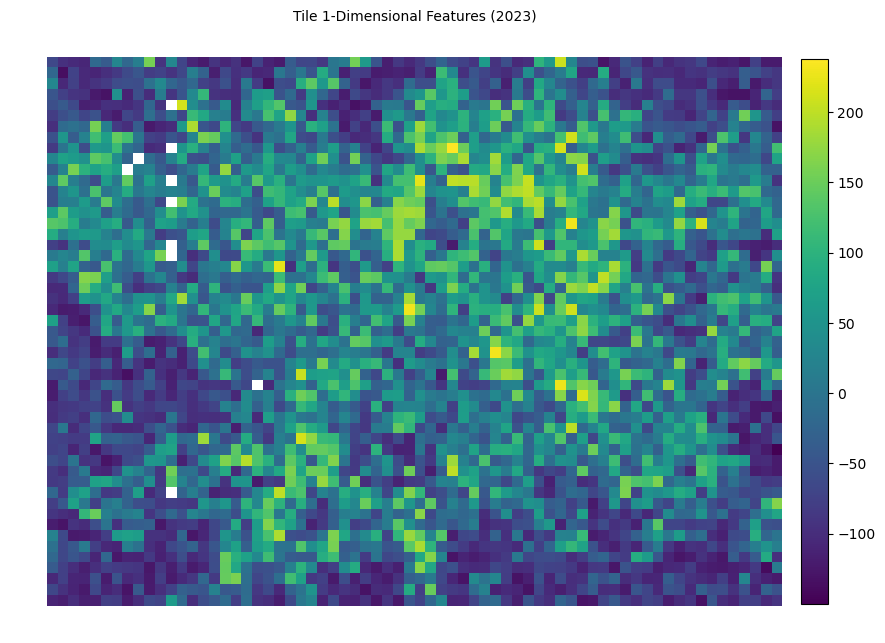

In [73]:
# Plot cluster_location_info with PCA as the color (remember that its a geoDataFrame with geometry column)
fig, ax = plt.subplots(figsize=(12, 12))
cluster_location_info.plot(column='pca', ax=ax, legend=True, legend_kwds={'shrink':0.59, 'pad': -0.02})

# Remove axis
ax.axis('off')

# Add title
plt.title("Tile 1-Dimensional Features (2023)", fontsize=10)

plt.show()

## Inflows and Outflows

In [148]:
# Get all 2-grams from n_gram_counts
two_grams = {n_gram: count for n_gram, count in n_gram_counts.items() if len(n_gram) == 2}

In [150]:
# Create a pivot table DataFrame from the two_grams dictionary. Rows should be the first element of the n-gram, columns should be the second element, and the values should be the count.
# Start by creating a DataFrame from the dictionary
two_grams_df = pd.DataFrame.from_dict(two_grams, orient='index', columns=['count'])

# Reset the index to get the n-grams as columns
two_grams_df = two_grams_df.reset_index()

# Extract the first and second elements of the n-gram into separate columns
two_grams_df[['Initial Cluster', 'Subsequent Cluster']] = pd.DataFrame(two_grams_df['index'].tolist(), index=two_grams_df.index)

# Drop the index column
two_grams_df = two_grams_df.drop(columns=['index'])

# Pivot the DataFrame
two_grams_df = two_grams_df.pivot(index='Initial Cluster', columns='Subsequent Cluster', values='count').fillna(0)

In [106]:
key_clusters

[30, 31, 32, 33, 37, 39]

In [151]:
# Add row and column called Other
# Calculate the sum for the 'Other' column excluding key_clusters rows
two_grams_df['Other'] = two_grams_df.drop(columns=key_clusters).sum(axis=1)

# Calculate the sum for the 'Other' row excluding key_clusters columns
two_grams_df.loc['Other'] = two_grams_df.drop(index=key_clusters).sum(axis=0)

# Remove rows and columns that are not in key_clusters or 'Other'
two_grams_df = two_grams_df.loc[key_clusters + ['Other'], key_clusters + ['Other']]
two_grams_df

Subsequent Cluster,30,31,32,33,37,39,Other
Initial Cluster,,,,,,,
30,3320.0,470.0,215.0,671.0,230.0,217.0,69.0
31,403.0,931.0,209.0,133.0,159.0,137.0,34.0
32,197.0,218.0,1097.0,191.0,160.0,174.0,36.0
33,528.0,126.0,171.0,1672.0,82.0,62.0,21.0
37,206.0,185.0,191.0,91.0,835.0,282.0,50.0
39,226.0,112.0,180.0,63.0,309.0,1877.0,130.0
Other,85.0,40.0,43.0,22.0,60.0,140.0,230.0


In [152]:
# Get a cluster_counts with an 'Other' key that sums all the clusters not in key_clusters
other_count = sum(count for cluster, count in cluster_counts.items() if cluster not in key_clusters)

In [153]:
cluster_counts_with_other = {cluster: count for cluster, count in cluster_counts.items()}
cluster_counts_with_other['Other'] = other_count

# Remove clusters not in key_clusters
cluster_counts_with_other = {cluster: count for cluster, count in cluster_counts_with_other.items() if cluster in key_clusters or cluster == 'Other'}

In [154]:
# Divide each row by it's cluster count in cluster_counts_with_other
two_grams_df = two_grams_df.div([cluster_counts_with_other[cluster] for cluster in two_grams_df.index], axis=0)

In [160]:
two_grams_df

Subsequent Cluster,30,31,32,33,37,39,Other
Initial Cluster,,,,,,,
30,0.536956,0.076015,0.034773,0.108523,0.037199,0.035096,0.011160
31,0.165707,0.382812,0.085938,0.054688,0.065378,0.056332,0.013980
32,0.078237,0.086577,0.435663,0.075854,0.063542,0.069102,0.014297
33,0.161320,0.038497,0.052246,0.510846,0.025053,0.018943,0.006416
37,0.093850,0.084282,0.087016,0.041458,0.380410,0.128474,0.022779
39,0.066295,0.032854,0.052801,0.018480,0.090642,0.550601,0.038134
Other,0.115176,0.054201,0.058266,0.029810,0.081301,0.189702,0.311653


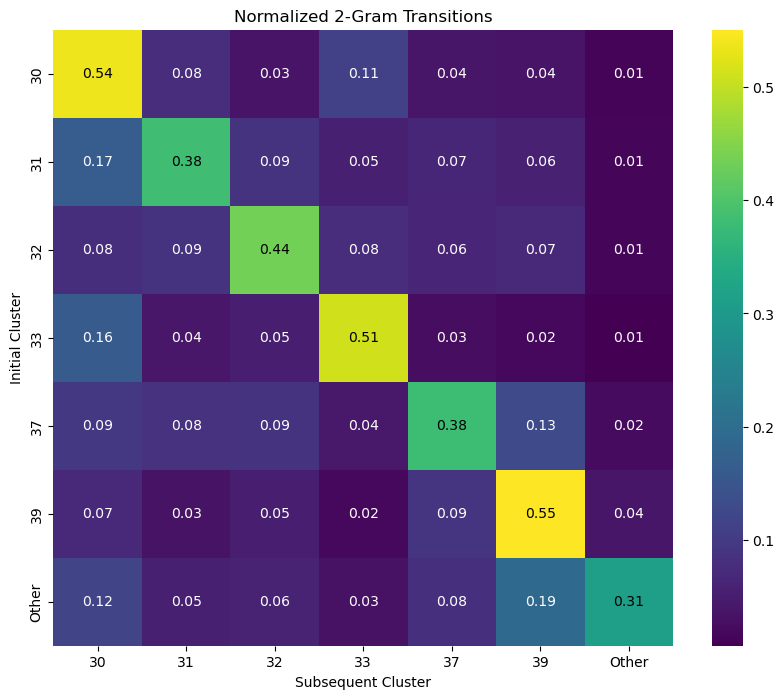

In [171]:
# Create a heatmap of the two_grams_df DataFrame
plt.figure(figsize=(10, 8))
ax = sns.heatmap(two_grams_df, cmap='viridis', annot=False, fmt='.2f')

# Manually add annotations
for i in range(two_grams_df.shape[0]):
    for j in range(two_grams_df.shape[1]):
        value = two_grams_df.iloc[i, j]
        color = 'white' if value < 0.2 else 'black'
        text = ax.text(j + 0.5, i + 0.5, f'{value:.2f}',
                       ha='center', va='center', color=color, fontsize=10)

plt.title("Normalized 2-Gram Transitions")
plt.show()

In [182]:
# Get cluster counts per year (create df with rows as clusters and columns as years)
cluster_counts_per_year = pd.DataFrame(columns=years, index=range(50))

# Set all values to 0
cluster_counts_per_year = cluster_counts_per_year.fillna(0)

C:\Users\Juanes\AppData\Local\Temp\ipykernel_7536\1637576043.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cluster_counts_per_year = cluster_counts_per_year.fillna(0)


In [188]:
sequences

[[27, 39, 39, 39, 39, 39],
 [39, 39, 39, 37, 37, 39],
 [32, 39, 39, 32, 39, 39],
 [39, 39, 39, 39, 39, 39],
 [31, 31, 31, 31, 31, 31],
 [33, 33, 30, 30, 30, 30],
 [33, 33, 33, 33, 33, 33],
 [33, 30, 30, 30, 33, 30],
 [30, 30, 30, 30, 30, 30],
 [30, 30, 30, 30, 30, 30],
 [30, 30, 30, 30, 27, 30],
 [30, 30, 30, 30, 30, 30],
 [30, 30, 30, 33, 33, 33],
 [33, 30, 30, 30, 30, 30],
 [39, 39, 39, 39, 39, 39],
 [32, 32, 32, 32, 31, 32],
 [32, 32, 32, 31, 31, 31],
 [30, 30, 30, 30, 30, 30],
 [30, 30, 31, 31, 31, 31],
 [30, 30, 30, 30, 30, 30],
 [30, 30, 30, 33, 33, 30],
 [33, 33, 33, 33, 30, 30],
 [39, 39, 39, 39, 39, 39],
 [39, 39, 39, 39, 39, 39],
 [39, 39, 39, 39, 39, 39],
 [27, 39, 39, 39, 46, 46],
 [32, 32, 32, 32, 37, 31],
 [39, 37, 39, 39, 37, 37],
 [37, 37, 37, 37, 37, 37],
 [32, 39, 39, 32, 32, 32],
 [30, 30, 33, 33, 33, 33],
 [32, 32, 32, 32, 32, 32],
 [33, 33, 33, 33, 33, 33],
 [30, 30, 30, 30, 30, 33],
 [33, 33, 33, 33, 33, 33],
 [32, 32, 33, 33, 33, 33],
 [39, 39, 39, 39, 31, 39],
 

In [192]:
for sequence in sequences:
    for j, year in enumerate(years):
        cluster_counts_per_year.loc[sequence[j], year] += 1

In [193]:
cluster_counts_per_year

,2018,2019,2020,2021,2022,2023
0,2,1,1,1,1,1
1,1,1,2,1,1,1
2,2,1,1,1,1,1
3,2,1,1,1,1,1
4,2,1,1,1,1,1
5,2,1,1,1,1,1
6,1,1,2,1,1,1
7,1,1,1,2,1,2
8,2,3,3,2,2,2
9,2,1,1,1,1,1


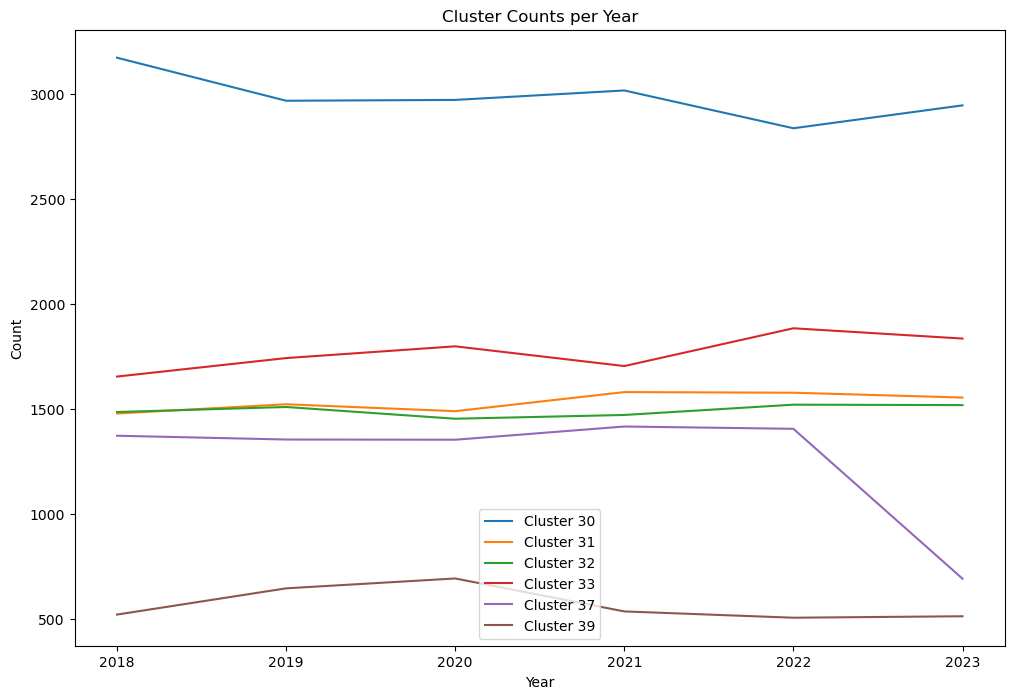

In [194]:
# Plot the cluster counts per year for the key_clusters
plt.figure(figsize=(12, 8))
for cluster in key_clusters:
    plt.plot(years, cluster_counts_per_year.loc[cluster], label=f"Cluster {cluster}")

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Cluster Counts per Year")
plt.legend()
plt.show()